In [1]:
!pip install thop scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, f1_score, precision_score, recall_score
from thop import profile, clever_format


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dataset path
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(DATA_DIR, transform=transform)
# Split 50:50 Train:Test
test_ratio = 0.5
test_size = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Split 10% of train as validation
val_ratio = 0.1
val_size = int(val_ratio * len(train_dataset))
train_size_final = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size_final, val_size])

# Dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Classes
classes = dataset.classes
num_classes = len(classes)
print(f"Classes: {classes}")
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Using device: cuda
Classes: ['Genus Criconema', 'Genus Criconemoides', 'Genus Helicotylenchus', 'Genus Hemicycliophora', 'Genus Hirschmaniella', 'Genus Hoplolaimus', 'Genus Meloidogyne', 'Genus Pratylenchus', 'Genus Radopholus', 'Genus Trichodorus', 'Genus Xiphinema']
Train: 458, Val: 50, Test: 508


In [4]:
# Load ViT-B16 pretrained
vit_model = models.vit_b_16(weights="IMAGENET1K_V1")

# Replace head
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)
vit_model = vit_model.to(device)

# GFLOPs & Params
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"GFLOPs: {flops}, Parameters: {params}")


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 236MB/s] 


GFLOPs: 11.285G, Parameters: 57.307M


In [5]:
dummy_input = torch.randn(1, 3, 224, 224).to(device)
flops, params = profile(vit_model, inputs=(dummy_input,), verbose=False)
flops, params = clever_format([flops, params], "%.3f")
print(f"GFLOPs: {flops}, Parameters: {params}")


GFLOPs: 11.285G, Parameters: 57.307M


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-4)



In [7]:
num_epochs = 50

for epoch in range(num_epochs):
    vit_model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    vit_model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vit_model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch [1/50] Train Loss: 2.0352, Train Acc: 0.2489 | Val Loss: 1.5975, Val Acc: 0.5400
Epoch [2/50] Train Loss: 1.1714, Train Acc: 0.6310 | Val Loss: 1.2215, Val Acc: 0.5400
Epoch [3/50] Train Loss: 0.5139, Train Acc: 0.8450 | Val Loss: 1.2334, Val Acc: 0.6000
Epoch [4/50] Train Loss: 0.1952, Train Acc: 0.9520 | Val Loss: 1.2881, Val Acc: 0.6400
Epoch [5/50] Train Loss: 0.1501, Train Acc: 0.9541 | Val Loss: 1.2481, Val Acc: 0.6600
Epoch [6/50] Train Loss: 0.0394, Train Acc: 0.9934 | Val Loss: 1.4110, Val Acc: 0.5800
Epoch [7/50] Train Loss: 0.0126, Train Acc: 1.0000 | Val Loss: 1.1936, Val Acc: 0.7200
Epoch [8/50] Train Loss: 0.0067, Train Acc: 1.0000 | Val Loss: 1.2666, Val Acc: 0.7200
Epoch [9/50] Train Loss: 0.0036, Train Acc: 1.0000 | Val Loss: 1.1697, Val Acc: 0.7000
Epoch [10/50] Train Loss: 0.0028, Train Acc: 1.0000 | Val Loss: 1.1844, Val Acc: 0.7200
Epoch [11/50] Train Loss: 0.0023, Train Acc: 1.0000 | Val Loss: 1.2109, Val Acc: 0.7400
Epoch [12/50] Train Loss: 0.0021, Train A

In [8]:
all_labels = []
all_preds = []
all_probs = []

vit_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = vit_model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


In [9]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-score: {f1:.4f}")

# Classification report with explicit labels
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(classes))),  # ensures all classes are included
    target_names=classes,
    zero_division=0
))


Test Accuracy: 0.7717
Test Precision: 0.7971
Test Recall: 0.7717
Test F1-score: 0.7685

Classification Report:
                       precision    recall  f1-score   support

      Genus Criconema       1.00      0.50      0.67         2
  Genus Criconemoides       0.92      0.82      0.87        44
Genus Helicotylenchus       0.92      0.81      0.86        72
Genus Hemicycliophora       0.00      0.00      0.00         2
 Genus Hirschmaniella       0.85      0.59      0.70        68
    Genus Hoplolaimus       0.81      0.87      0.84        78
    Genus Meloidogyne       0.77      0.85      0.81       103
   Genus Pratylenchus       0.50      0.73      0.59        55
     Genus Radopholus       1.00      0.26      0.42        19
    Genus Trichodorus       0.91      0.95      0.93        21
      Genus Xiphinema       0.68      0.82      0.74        44

             accuracy                           0.77       508
            macro avg       0.76      0.65      0.67       508
     

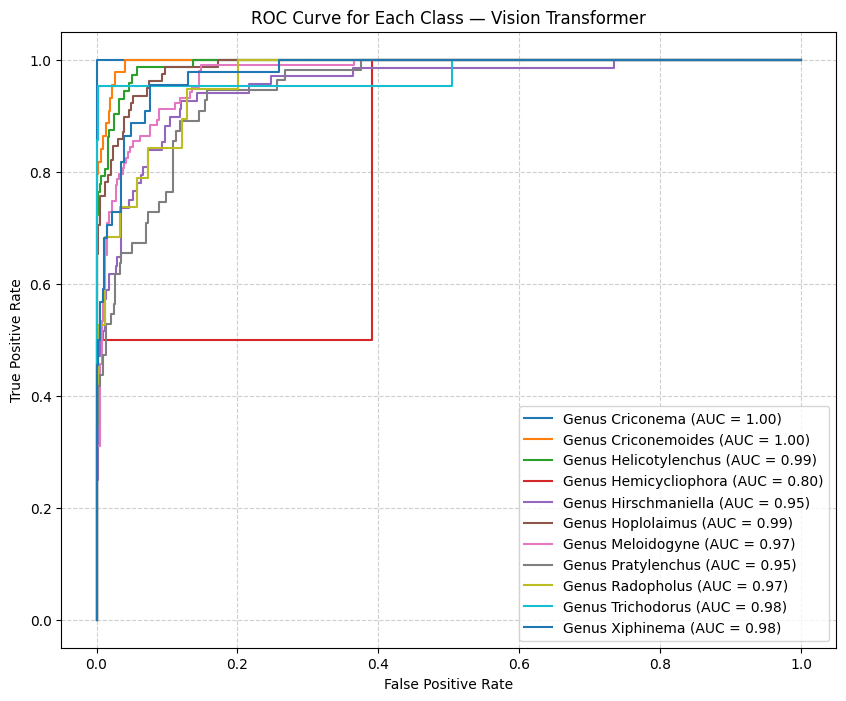

In [11]:
plt.figure(figsize=(10, 8))

for i, cls in enumerate(classes):
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class — Vision Transformer")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
